In [2]:
import cv2
import matplotlib.pyplot as plt

1080 1440 3


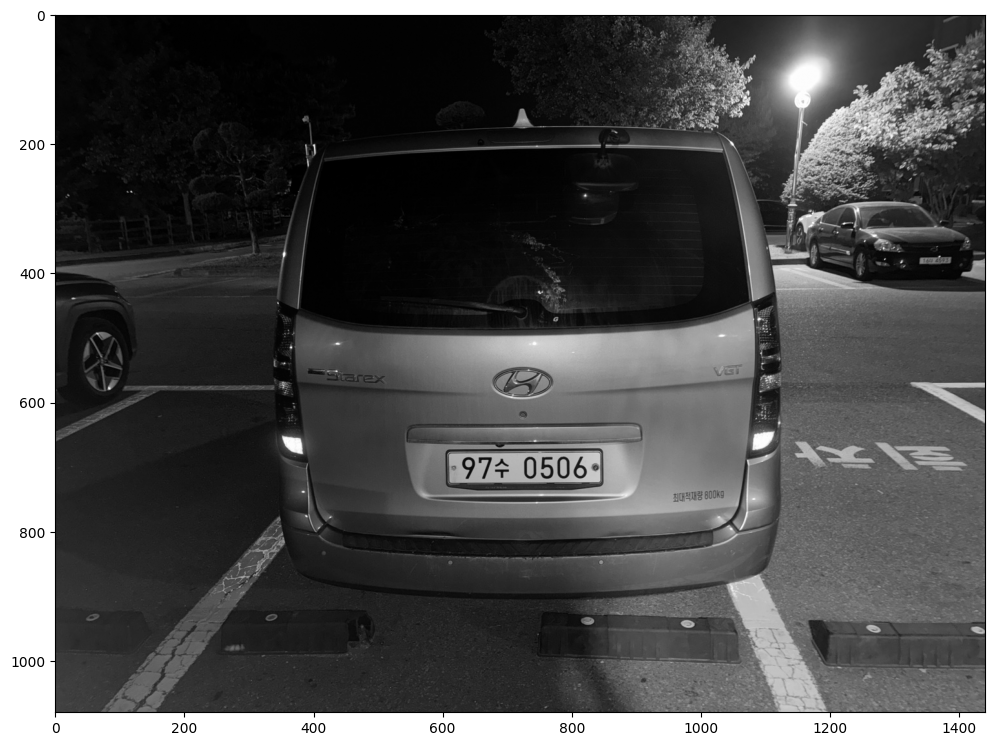

In [32]:
# 1. 이미지 로드 후 회색 이미지로 변환해 시각화
#-------------------------------------
img = cv2.imread('/content/KakaoTalk_Photo_2025-05-21-21-23-57 001.jpeg')

height, width, channel = img.shape

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12, 10))
plt.imshow(gray,cmap='gray')
print(height, width, channel)

In [12]:
# 2. 이미지 흐림 처리: 노이즈 제거 및 엣지 검출 전처리용
#--------------------------------------------
img_blurred = cv2.GaussianBlur(gray, ksize=(3,3), sigmaX=0) # 3x3 커널을 사용한 가우시안 블러 적용

img_blur_thresh = cv2.Laplacian(img_blurred, ddepth=cv2.CV_8U) # 라플라시안 필터 적용: 이미지의 윤곽선(경계선) 강조

img_canny = cv2.Canny(img_blur_thresh, threshold1=100, threshold2=200) # Canny 엣지 검출 적용: 윤곽선(경계선)을 추출, 최소 : 100 ~ 최대 : 200 임계값

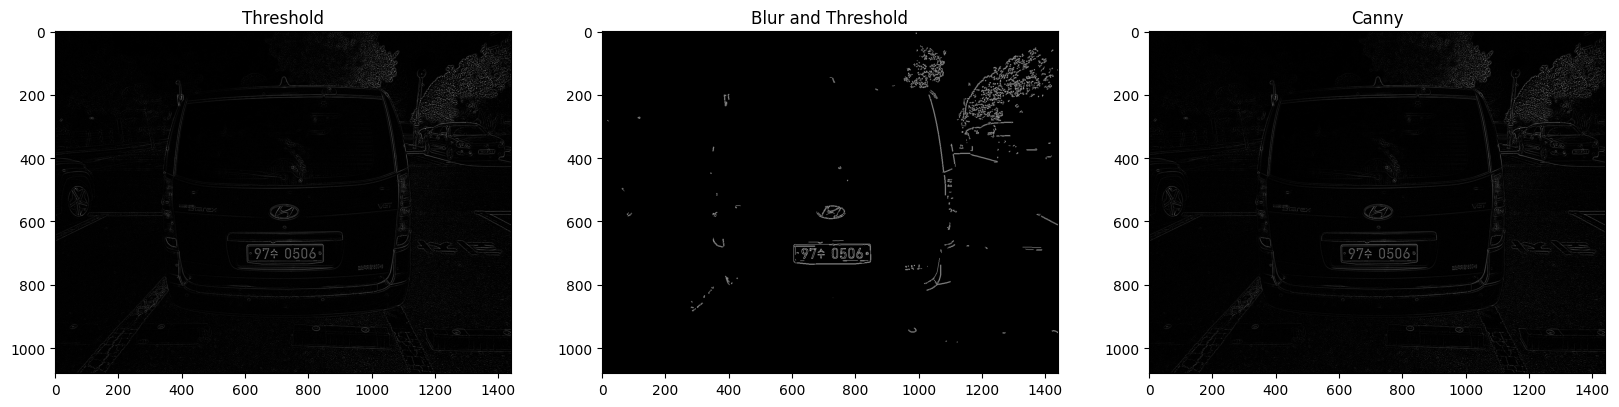

In [33]:
# 각 블러마다 시각화
#---------------
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title('Threshold')
plt.imshow(img_blur_thresh, cmap='gray')
plt.subplot(1,3,2)
plt.title('Blur and Threshold')
plt.imshow(img_canny, cmap='gray')
plt.subplot(1,3,3)
plt.title('Canny')
plt.imshow(img_blur_thresh, cmap='gray')

개수 : 1


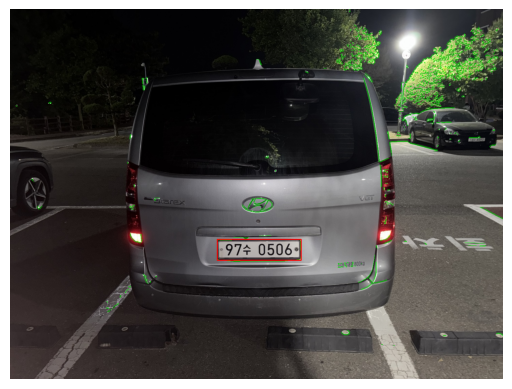

In [37]:
# 3. 윤곽선 검출
#-------------
import numpy as np

contours, _ = cv2.findContours(img_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 윤곽선 검출 (외곽선만)

cv2.drawContours(img, contours, -1, (0, 255, 0), 1) # 모든 윤곽선을 원본 이미지 위에 초록색으로 얇게 표시

candidates = [] # 후보를 저장할 리스트 초기화

for cnt in contours: # 윤곽선 하나씩 순회하며 사각형 조건에 맞는 것 선별
  perimeter = cv2.arcLength(cnt, True) # 윤곽선 전체 길이
  approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True) # 유사 다각형 근사 epsilon을 0.02 * 윤곽선 길이로(생략 정도), 윤곽선이 닫힌 것을 다각형으로 여부 판별

  if len(approx) == 4: # 꼭짓점이 4개이면 사각형으로 판단
        x, y, w, h = cv2.boundingRect(approx)
        area = cv2.contourArea(cnt)
        aspect_ratio = w / float(h)

        if area > 1000 and 2.0 < aspect_ratio < 6.0:
            candidates.append((x, y, w, h, approx)) # 조건 만족시에, 리스트에 추가

print("개수 :",len(candidates))

img_candidate = img.copy()
for (x, y, w, h, approx) in candidates: # 후보 사각형을 빨간색 박스로 표시
  cv2.rectangle(img_candidate, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.axis('off') # 시각화 부분
plt.imshow(cv2.cvtColor(img_candidate, cv2.COLOR_BGR2RGB))
plt.show()

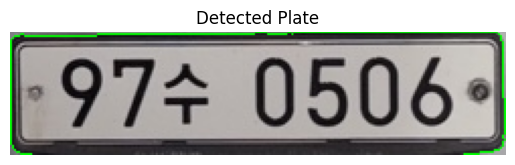

In [38]:
best_candidate = max(candidates, key=lambda c: c[2] * c[3])
# candidates = [(x, y, w, h, approx), ...] 배열에서 3번째 W, 4번째 H 값을 곱한 사각형 넓이 가장 큰 것을 구함

x, y, w, h, approx = best_candidate

plate_img = img[y:y+h, x:x+w]
# 원본 이미지(img)에서 후보 사각형 영역을 잘라냄

# 번호판 시각화
plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Plate')
plt.show()

In [42]:
# 문자 OCR을 위해, Tesseract OCR 설치
!apt install tesseract-ocr -y
!pip install pytesseract
!apt-get install tesseract-ocr-kor

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-kor
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,052 kB of archives.
After this operation, 1,693 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-kor all 1:4.00~git30-7274cfa-1.1 [1,052 kB]
Fetched 1,052 kB in 1s (811 kB/s)
Selecting previously unselected package tesseract-ocr-kor.
(Reading database ... 126102 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-kor_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-kor (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-

In [58]:
import pytesseract
import re
import cv2

gray_plate = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY) # 번호판 이미지 → 그레이스케일 이미지로 변환

gray_plate = cv2.bilateralFilter(gray_plate, d=9, sigmaColor=75, sigmaSpace=75) # 노이즈 제거 - 글자를 더 잘 인식하기 위함

_, thresh_plate = cv2.threshold(gray_plate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Otsu 이진화 (글자 대비 강조)

resized_plate = cv2.resize(thresh_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC) # 정확도 향상을 위해 크기 재조정, 가로 세로를 각각 2배씩 확대

text = pytesseract.image_to_string(resized_plate, config='--psm 7', lang='kor') # Tesseract OCR 실행 (한글+영문 혼합, 단일 텍스트 줄 모드)

text = re.sub(r'[^0-9가-힣\s]', '', text) # 특수문자 제거 (숫자, 한글, 공백만 유지)

text = text.replace('쑤', '수').replace('추', '수').replace('오O', '050')  # 잘못된 인식을 위한 보정 추가

text = text.strip()

print("번호판 인식 결과:", text) # 결과 출력

번호판 인식 결과: 97수 0506


### ***추가 자료, OCR 문자 인식 개선을 위한 코드 추가 설명***

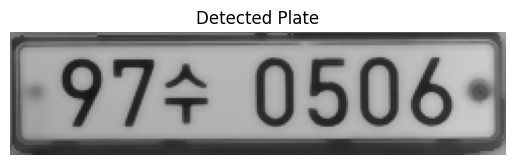

In [48]:
# OCR 문자 인식 개선을 위한 노이즈 제거, 바로 전 코드에서 bilateralFilter의 결과 시각화
plt.imshow(cv2.cvtColor(gray_plate, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Plate')
plt.show()

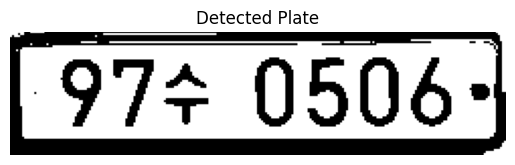

In [49]:
# OCR 문자 인식 개선을 위한 노이즈 제거, 바로 전 코드에서 Otsu 이진화의 결과 시각화
plt.imshow(cv2.cvtColor(thresh_plate, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Plate')
plt.show()